<a href="https://colab.research.google.com/github/NRC-Lund/radiation-WM/blob/main/WM_analysis_Frequency_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns

from matplotlib import style, offsetbox
import matplotlib.cm as cm
style.use('ggplot') or plt.style.use('ggplot')

import scipy.stats as stats
from scipy.cluster.hierarchy import dendrogram
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

import sklearn.feature_selection as featsel
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors, metrics)
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, confusion_matrix, f1_score, classification_report, accuracy_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.feature_selection import (f_classif, VarianceThreshold, chi2, mutual_info_classif, SelectKBest,
                                       SelectPercentile)
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from ipywidgets import interact, widgets

import os

import time

import warnings
warnings.filterwarnings('ignore')


In [ ]:
#define seaborn background colors
#sns.despine();
sns.set_style("whitegrid")
plt.rcParams['axes.edgecolor'] = '#000000'
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.bottom'] = True
#plt.rcParams['ytick.labelleft'] = True

### Loading Data

In [ ]:
Colab_flag = True

In [ ]:
if Colab_flag:
  from google.colab import drive
  drive.mount('/content/drive')
  homeFolder = '/content/drive/MyDrive/Colab Notebooks/WM/'
else:
  homeFolder = '/Users/sbk/Documents/Lab/WM/'

picFolder = homeFolder + 'Pics/'

Mounted at /content/drive


#Behavior

In [ ]:
# Statistical evaluation
def getpval(df, var):
    # Hypothesis test: compare the means of two treatments
    treatment_a = df[(df['Treatment'] == 'Control') | (df['Treatment'] == 'CTRL')][var]
    treatment_b = df[df['Treatment'] == 'WB'][var]
    t_statistic, p_value = stats.mannwhitneyu(treatment_a, treatment_b, nan_policy='omit')
    return t_statistic, p_value


In [ ]:
def bootstrap_test(distribution1, distribution2):
    num_samples = 10000
    confidence_level = 0.95

    # Compute the observed statistic
    observed_statistic = np.mean(distribution1) - np.mean(distribution2)

    # Combine the two distributions
    combined_data = np.concatenate((distribution1, distribution2))

    # Initialize an array to store the bootstrap statistics
    bootstrap_statistics = np.zeros(num_samples)

    # Perform bootstrapping
    for i in range(num_samples):
        # Generate a bootstrap sample
        bootstrap_sample = np.random.choice(combined_data, size=len(combined_data), replace=True)

        # Compute the statistic for the bootstrap sample
        bootstrap_statistic = np.mean(bootstrap_sample[:len(distribution1)]) - np.mean(bootstrap_sample[len(distribution1):])

        # Store the bootstrap statistic
        bootstrap_statistics[i] = bootstrap_statistic

    # Compute the p-value
    p_value = (np.abs(bootstrap_statistics) >= np.abs(observed_statistic)).mean()

    # Compute the confidence interval
    alpha = (1 - confidence_level) / 2
    lower_bound = np.percentile(bootstrap_statistics, alpha * 100)
    upper_bound = np.percentile(bootstrap_statistics, (1 - alpha) * 100)

    # Return the observed statistic, p-value, and confidence interval
    return observed_statistic, p_value, (lower_bound, upper_bound)

#observed_statistic, p_value, confidence_interval = bootstrap_test(distribution1, distribution2)

#print("Observed statistic:", observed_statistic)
#print("P-value:", p_value)
#print("Confidence interval:", confidence_interval)


In [ ]:
def remove_outliers(df, column_name, multiplier=1.5):
    """
    Remove outliers from a specific column in a DataFrame using the IQR method.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - column_name (str): The name of the column from which outliers will be removed.
    - multiplier (float): The multiplier to determine the outlier threshold (default is 1.5).

    Returns:
    - pd.DataFrame: DataFrame without outliers in the specified column.
    """

    # Select the specified column
    column_data = df[column_name]

    # Calculate the IQR (Interquartile Range)
    Q1 = column_data.quantile(0.25)
    Q3 = column_data.quantile(0.75)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    # Filter out rows with values outside the bounds
    df_filtered = df[(column_data >= lower_bound) & (column_data <= upper_bound)]

    return df_filtered


In [ ]:
def ttxpalette(bTtx):
  TtxNames = ['Control', 'CS', 'HF', 'WB'];
  #colors2 = ['#3f51b5', '#ffa700', '#34a853', '#ea4335'];
  colors2 = ['#3f51b5', '#ffa700', '#ffa700', '#ffa700'];

  # Create a dictionary to map TtxNames to colors
  color_dict = {ttx: color for ttx, color in zip(TtxNames, colors2)}

  # Create a list of colors corresponding to TtxNames
  bpalette = [color_dict[ttx] for ttx in bTtx]

  # Set the seaborn palette
  sns.set_palette(bpalette)

  return bpalette

def epochpalette(bEpoch = ['Start', 'Cue', 'Running', 'Reward', 'Timeout']):
  EpochNames = ['Start', 'Cue', 'Running', 'Reward', 'Outcome', 'Timeout', 'TimeOut'];
  colors2 = ['#d11141', '#00b159', '#00aedb', '#f37735', '#f37735', '#767676', '#767676'];

  # Create a dictionary to map TtxNames to colors
  color_dict = {ex: color for ex, color in zip(EpochNames, colors2)}

  # Create a list of colors corresponding to TtxNames
  bpalette = [color_dict[ex] for ex in bEpoch]

  # Set the seaborn palette
  sns.set_palette(bpalette)

  return bpalette

def strpalette(bStructure = ['plPFC', 'ilPFC', 'OFC', 'M2', 'DLS', 'NAcCore', 'PPC', 'dHipp', 'vHipp', 'MDT']):
  StrNames = ['plPFC', 'ilPFC', 'OFC', 'M2', 'DLS', 'NAcCore', 'nAc', 'PPC', 'dHipp', 'vHipp', 'MDT']
  colors2 = ['#ff1000', '#ff5000', '#ff8000', '#ffaf00', '#52b855', '#245923', '#245923', '#3f20c0', '#3f63c0', '#3fa7c0', '#800eec'];

  # Create a dictionary to map TtxNames to colors
  color_dict = {ex: color for ex, color in zip(StrNames, colors2)}

  # Create a list of colors corresponding to TtxNames
  bpalette = [color_dict[ex] for ex in bStructure]

  # Set the seaborn palette
  sns.set_palette(bpalette)

  return bpalette


In [ ]:
def plotbars(df, x, y, ax, hue = [], swarmFlag = False, palette = 'colorblind'):

  if np.isempty(hue):
    sns.barplot(data=df, x=x, y=y, ax = ax,capsize=.2, errwidth = 1.5,
                linewidth=1.5, edgecolor=".5", palette = palette, ci=68)
  else:
    sns.barplot(data=df, x=x, y=y, ax = ax, hue = hue, capsize=.2, errwidth = 1.5,
                linewidth=1.5, edgecolor=".5", palette = palette, ci=68)

  if swarmFlag:
    sns.stripplot(data=df, x=x, y=y, s = 5, ax = ax, color = '.2', edgecolor = 'k', alpha = 0.5)



## Performance Analysis

In [ ]:
path = homeFolder + 'FractalTable.csv'
L= pd.read_csv(path)
L.head(3)

,Rec,nTrial,Trial,Epoch,Treatment,Hemisphere,Structure,Speed,Acc,Theta,Beta,Gamma,fTheta,fBeta,fGamma
0,Rec1,1,HIT,Start,Control,L,DLS,18.851702,0.084503,-0.886042,-0.853218,0.569239,5.75,20.0,47.00
1,Rec1,2,HIT,Start,Control,L,DLS,5.385658,0.087147,-0.803077,0.335654,0.908059,4.25,17.5,49.75
2,Rec1,3,HIT,Start,Control,L,DLS,0.180555,0.091434,0.254699,-1.212263,1.390533,6.25,16.5,43.75


In [ ]:
bHemi = np.unique(L.Hemisphere)
bRec = np.unique(L.Rec)
bStructure = ['plPFC', 'OFC', 'DLS', 'NAcCore', 'PPC', 'dHipp', 'MDT']
bEpoch = ['Start', 'Cue', 'Running', 'Reward', 'TimeOut']

rec = []
ttx = []
perf = []
ntrials = []

for rx in range(len(bRec)):
    idx = 0
    dummy = L[(L.Hemisphere == bHemi[0]) &
              (L.Rec == bRec[rx]) &
              (L.Structure == bStructure[idx]) &
              (L.Epoch == bEpoch[0])]

    if len(dummy) == 0:
        while True:
            idx = idx + 1
            if idx >= len(bStructure):
                break

            dummy = L[(L.Hemisphere == bHemi[0]) &
                      (L.Rec == bRec[rx]) &
                      (L.Structure == bStructure[idx]) &
                      (L.Epoch == bEpoch[0])]

            if len(dummy) > 0:
                break

    xresp = np.nansum(dummy.Trial == 'HIT') / len(dummy)
    perf.append(xresp)
    ttx.append(np.unique(dummy.Treatment)[0])  # fix to append the actual treatment value
    rec.append(bRec[rx])
    ntrials.append(np.nansum(len(dummy)))

df = pd.DataFrame({'Rec': rec, 'Treatment': ttx, 'Performance': perf, 'NTrials': ntrials})


In [ ]:
TtxNames = ['Control', 'WB']

In [ ]:
from scipy.optimize import curve_fit

# Define the sigmoid function
def sigmoid(x, a, b, c, d):
    y = c / (1 + np.exp(-a*(x-b))) + d
    return y

df2 = df[(df.Performance > 0.3)]
mask = (df2.Performance > 0.5) & (df2.NTrials < 15)
df2 = df2[~mask];

df2.reset_index(inplace = True, drop = True)
# Define the data to fit
xdata = df2['NTrials']
ydata = df2['Performance']

# Set initial parameter values for the sigmoid function
p0 = [1, np.mean(xdata), 1, np.mean(ydata)]

# Fit the sigmoid function to the data using 'lm' method
popt, pcov = curve_fit(sigmoid, xdata, ydata, p0, method='lm')


### Remove sessions with low performance:

In [ ]:
#Select only the recordings that fit
bStructure = ['plPFC', 'OFC', 'DLS', 'NAcCore', 'PPC', 'dHipp', 'MDT']
dummy = df2[(df2.Performance > 0.5)]
Data = L[np.in1d(L.Rec, dummy.Rec) & np.in1d(L.Structure, bStructure)]
Data.reset_index(inplace = True, drop = True);


In [ ]:
def cohens_d(group1, group2):
    """
    Calculate Cohen's d effect size.

    Parameters:
    - group1 (array-like): Data for group 1.
    - group2 (array-like): Data for group 2.

    Returns:
    - float: Cohen's d effect size.
    """

    # Calculate means
    mean1, mean2 = np.mean(group1), np.mean(group2)

    # Calculate pooled standard deviation
    pooled_std = np.sqrt((np.var(group1) + np.var(group2)) / 2)

    # Calculate Cohen's d
    d = (mean1 - mean2) / pooled_std

    return d


In [ ]:
def sigSymbol(P):
  if P >= 0.05:
    sig = ' '
  else:
    sig = '*'
    if P <= 0.00001:
      sig = '***'
    elif P <= 0.001:
      sig = '**'
  return sig

### Peak Frequency

In [ ]:
def checkNaNs(array):
    sz = np.size(array,0)
    log = [];
    for ix in range(sz):
        log.append(sum(np.isnan(array[ix]))>0)
        #print(sum(np.isnan(array[ix])))
    return np.array(log);

In [ ]:
def plotFreq(Data, bStructure, Trial, band):
    for ix in range(len(bStructure)):
        fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True)
        structure = bStructure[ix]

        for epoch in Data.Epoch.unique():
            group1 = Data[(Data.Structure == structure) &
                          (Data.Trial == Trial) &
                          (Data.Epoch == epoch) &
                          (Data.Treatment == 'Control')][f'f{band}']

            group2 = Data[(Data.Structure == structure) &
                          (Data.Trial == Trial) &
                          (Data.Epoch == epoch) &
                          (Data.Treatment == 'WB')][f'f{band}']

            t, p = stats.ttest_ind(group1, group2)
            p_str = f"p = {p:.4f}"  # format p-value as string

            # Calculate Cohen's d
            mean_diff = np.mean(group1) - np.mean(group2)
            pooled_std = np.sqrt((np.var(group1) + np.var(group2)) / 2)
            cohens_d = mean_diff / pooled_std

            # Perform Shapiro-Wilk test for normality
            _, normality_p1 = stats.shapiro(group1)
            _, normality_p2 = stats.shapiro(group2)
            is_normal1 = normality_p1 > 0.05
            is_normal2 = normality_p2 > 0.05

            ypos = max(group1.max(), group2.max()) + 0.2  # position text above plot
            xpos = Data.Epoch.unique().tolist().index(epoch)  # x position on plot
            ax.text(xpos, ypos, f"{p_str}\nCohen's d = {cohens_d:.4f}\nNormality: {is_normal1}, {is_normal2}", ha='center', va='bottom', fontsize=8)
            ax.text(xpos, ypos, f"{p_str}\nCohen's d = {cohens_d:.4f}\nNormality: {is_normal1}, {is_normal2}", ha='center', va='bottom', fontsize=8)

        sns.boxplot(data=Data[(Data.Structure == structure) & (Data.Trial == Trial)],
                    y=f'f{band}', x='Epoch', hue='Treatment', ax=ax, palette = 'colorblind')

        ax.set_ylabel(f'{band} Peak Freq [Hz]')
        ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
        ax.set_xlabel('')
        ax.set_title(f'{structure}')

    plt.tight_layout()


In [ ]:
def sort_matrix_by_vector(matrix, vector, order=['Start', 'Cue', 'Running', 'Reward', 'TimeOut'], axis=0):
    order_dict = {value: index for index, value in enumerate(order)}

    if axis == 0:
        sorted_indices = np.argsort([order_dict[value] for value in vector])
        sorted_matrix = matrix[sorted_indices]
        sorted_vector = [vector[i] for i in sorted_indices]
    elif axis == 1:
        sorted_indices = np.argsort([order_dict[value] for value in vector])
        sorted_matrix = matrix[:, sorted_indices]
        sorted_vector = [vector[i] for i in sorted_indices]
    else:
        raise ValueError("Invalid axis value. Must be 0 for rows or 1 for columns.")

    scores_vector = np.zeros(len(vector))
    for ix in range(len(order)):
        scores_vector[vector == order[ix]] = ix

    scores_vector = scores_vector[sorted_indices];
    return sorted_matrix, sorted_indices, scores_vector




Overall Spectrogram:

In [ ]:
path = homeFolder + 'FractalSpectra.csv'
S = pd.read_csv(path)
S.rename(columns = {'Trial': 'Outcome'}, inplace = True)
dummy = df2[(df2.Performance > 0.5)]
S = S[np.in1d(S.Rec, dummy.Rec) & np.in1d(S.Structure, bStructure)]
S.Structure[S.Structure == 'NAcCore'] = 'nAc'
S.Epoch[S.Epoch == 'Reward'] = 'Outcome'
S.dropna(subset='0', inplace=True)
S.reset_index(inplace=True, drop=True)
S.head(3)



,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,...,99.5,99.75,100,Rec,nTrial,Outcome,Epoch,Treatment,Hemisphere,Structure
0,0.029551,0.561136,1.713026,1.096055,0.203685,-0.900527,-3.212076,-5.631458,-4.988649,-3.201377,...,-2.496526,-6.628353,NaN,Rec2,1,FAIL,Start,Control,L,DLS
1,-0.323308,0.403545,1.962120,1.463460,-2.731695,-4.025594,-0.429524,1.189445,1.349718,0.698486,...,3.305460,1.322222,NaN,Rec2,2,HIT,Start,Control,L,DLS
2,-0.070316,0.679177,0.744315,-1.764483,-1.450816,1.676954,2.232849,0.235947,-3.611764,-5.004983,...,1.623431,0.481291,NaN,Rec2,3,HIT,Start,Control,L,DLS


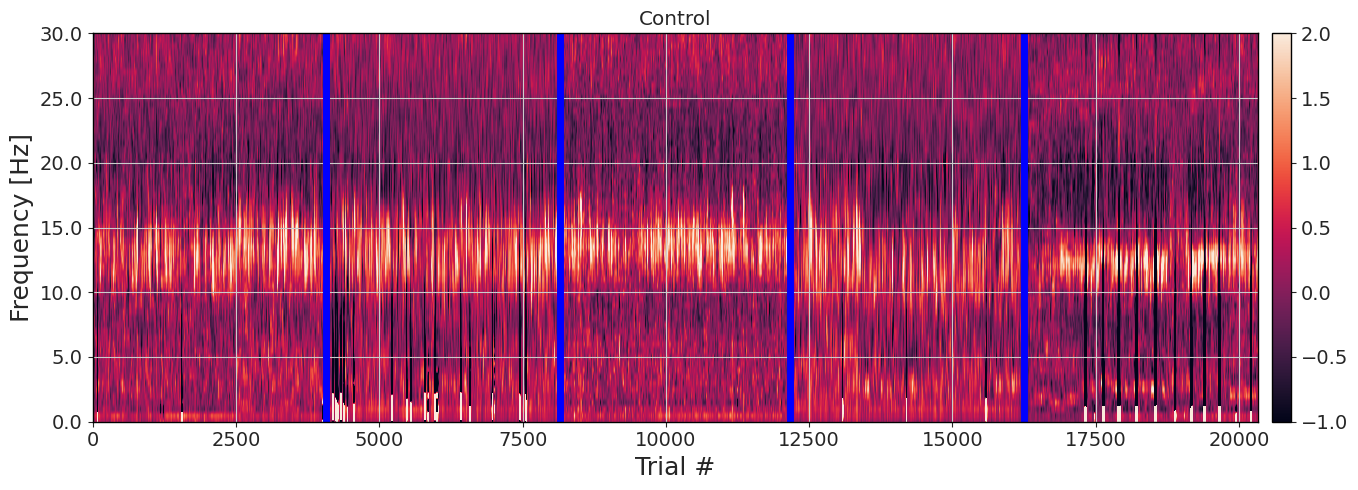

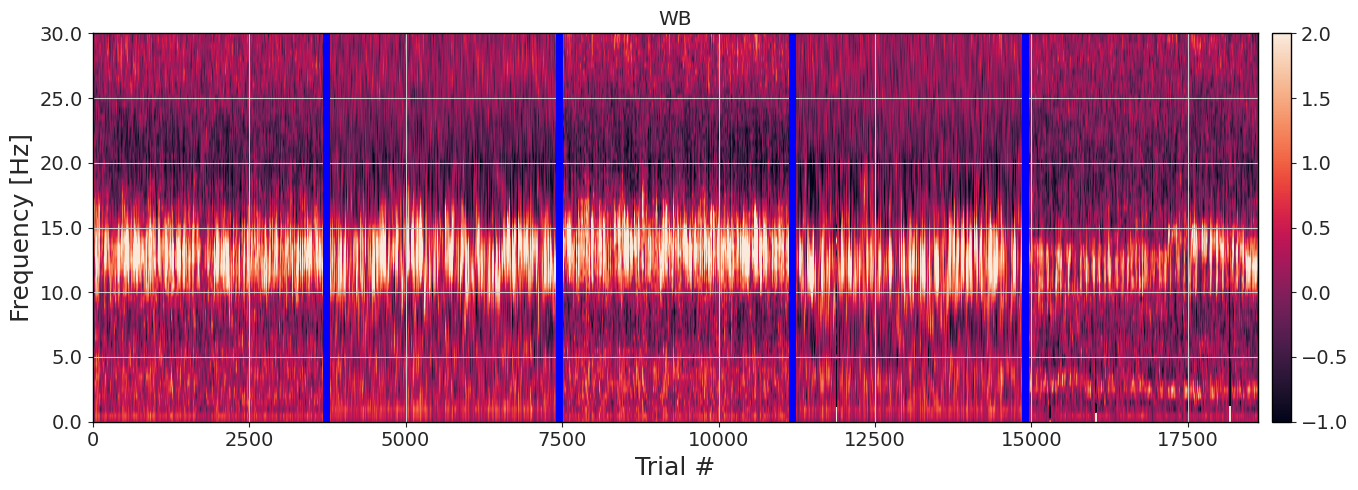

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

faxis = np.arange(0, 100, 0.5)
freqLim = [0, 30]
fsel = (faxis >= freqLim[0]) & (faxis <= freqLim[1])
scaler = MinMaxScaler()

spg = np.array(S.iloc[:, 0:len(faxis)])
spg = spg[:, fsel]
bInf = np.isinf(spg)
spg[bInf] = np.nan

Treatment = ['Control', 'WB']
selTrial = 'HIT'

replotFlag = True
for ttx in Treatment:
    fname = picFolder + f'Global_FractalSpg_{ttx}.png'
    sel = (S['Treatment'] == ttx)
    xEpoch = S['Epoch'][sel]
    xEpoch.reset_index(inplace=True, drop=True)

    result = spg[sel, :]

    bNaN = checkNaNs(result)
    result = result[~bNaN, :]
    sorted_epoch = xEpoch[~bNaN]
    sorted_epoch.reset_index(inplace=True, drop=True)
    sorted_indices = sorted_epoch.sort_values(
        key=lambda x: x.map({v: i for i, v in enumerate(bEpoch)})).index
    sorted_epoch = sorted_epoch[sorted_indices]
    sorted_epoch.reset_index(inplace=True, drop=True)
    result = result[sorted_indices, :]

    # Calculate z-scores using the baseline
    baseline = result[:, -20:]
    mean_baseline = baseline.mean(axis=1)[:, np.newaxis]
    std_baseline = baseline.std(axis=1)[:, np.newaxis]
    result = (result - mean_baseline) / std_baseline
    result = result.T
    # Alternatively, you can use MinMaxScaler
    # result = scaler.fit_transform(result.T).T

    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    pcm = ax.imshow(result, aspect='auto', vmin = -1, vmax = 2)
    ax.invert_yaxis()
    fig.colorbar(pcm, ax=ax, pad=0.01)

    yticks = np.arange(0, np.size(result, 0), step=10)  # Select every fourth tick
    yticklabels = faxis[fsel][yticks]  # Get the corresponding tick labels
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)

    ax.vlines(ymin=0, ymax=np.size(result, 0), x=sorted_epoch[sorted_epoch == 'Cue'].index[0], color='b',
              linewidth=5)
    ax.vlines(ymin=0, ymax=np.size(result, 0), x=sorted_epoch[sorted_epoch == 'Running'].index[0], color='b',
              linewidth=5)
    ax.vlines(ymin=0, ymax=np.size(result, 0), x=sorted_epoch[sorted_epoch == 'Outcome'].index[0], color='b',
              linewidth=5)
    ax.vlines(ymin=0, ymax=np.size(result, 0), x=sorted_epoch[sorted_epoch == 'TimeOut'].index[0], color='b',
              linewidth=5)

    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Trial #')
    ax.set_title(ttx)
    ax.grid(visible=True, axis='y')
    ax.set_ylim([np.argwhere(faxis == freqLim[0])[0][0], np.argwhere(faxis == freqLim[1])[0][0]])

    plt.tight_layout()
    plt.show()



In [ ]:
bEpoch = ['Start', 'Cue', 'Running', 'Outcome', 'TimeOut']

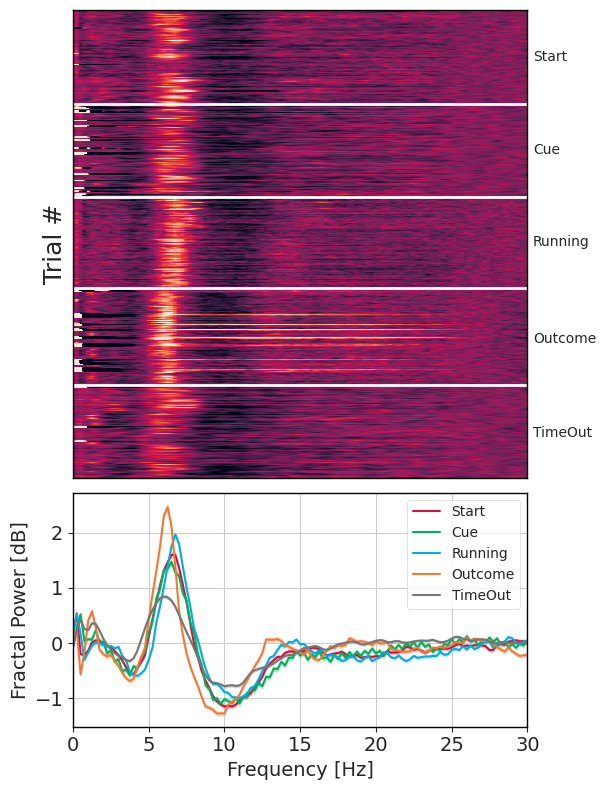

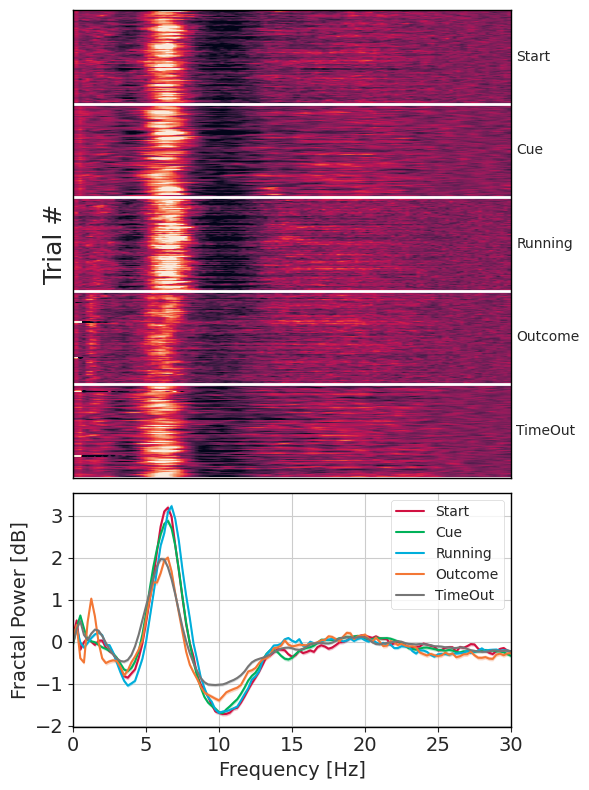

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd

def checkNaNs(array):
    return np.isnan(array).any(axis=1)

faxis = np.arange(0, 100, 0.25)
freq_lim = [0, 30]
fsel = (faxis >= freq_lim[0]) & (faxis <= freq_lim[1])
scaler = MinMaxScaler()

# Prepare spectra
spg = np.array(S.iloc[:, :len(faxis)])
spg = spg[:, fsel]
spg[np.isinf(spg)] = np.nan

Treatment = ['Control', 'WB']
bcolors = epochpalette(bEpoch)

xrec, xtrial, xepoch, xstructure, xtreatment, xoutcome, xhemisphere, xpower, xfreq = [], [], [], [], [], [], [], [], []

for ttx in Treatment:
    fname = f"{picFolder}Global_FractalSpg_{ttx}.png"
    sel = (S['Treatment'] == ttx)
    result = spg[sel]

    # Select by treatment
    xRec = S.Rec[sel].reset_index(drop=True)
    xEpoch = S['Epoch'][sel].reset_index(drop=True)
    xStructure = S.Structure[sel].reset_index(drop=True)
    xHemi = S.Hemisphere[sel].reset_index(drop=True)
    xOutcome = S.Outcome[sel].reset_index(drop=True)

    # Remove NaN rows
    bNaN = checkNaNs(result)
    result = result[~bNaN]
    xRec = xRec[~bNaN].reset_index(drop=True)
    xEpoch = xEpoch[~bNaN].reset_index(drop=True)
    xStructure = xStructure[~bNaN].reset_index(drop=True)
    xHemi = xHemi[~bNaN].reset_index(drop=True)
    xOutcome = xOutcome[~bNaN].reset_index(drop=True)

    # Sort by epoch
    sorted_indices = xEpoch.map({v: i for i, v in enumerate(bEpoch)}).sort_values().index
    result = result[sorted_indices,:]
    xRec = xRec[sorted_indices]
    xEpoch = xEpoch[sorted_indices]
    xStructure = xStructure[sorted_indices]
    xHemi = xHemi[sorted_indices]
    xOutcome = xOutcome[sorted_indices]

    # Calculate z-scores for the spectra
    baseline = result[:, -20:]
    mean_baseline = np.mean(baseline, axis=1)[:, np.newaxis]
    std_baseline = np.std(baseline, axis=1)[:, np.newaxis]
    result_orig = result.copy()
    result = (result - mean_baseline) / std_baseline
    result = result.T

    #1. plot spectra as a raster plot
    fig, ax = plt.subplots(2, 1, figsize=(6, 8), gridspec_kw={'height_ratios': [4, 2]})
    hax = ax[0]
    pcm = hax.imshow(result.T, aspect='auto', vmin = -1, vmax = 2)

    #draw horizontal lines to divide epochs:
    for k, epoch in enumerate(bEpoch):
      nTrials = np.sum(xEpoch == epoch)*(k+1)
      hax.hlines(xmin = 0, xmax=np.size(result, 1), y = nTrials, color = 'w', linewidth = 2)
      hax.text(np.size(result, 0)+1, np.nanmean([np.sum(xEpoch == epoch)*(k), nTrials]),
               epoch, horizontalalignment = 'left', verticalalignment = 'center')

    hax.set_xticks([])
    hax.set_yticks([])
    hax.set_ylabel('Trial #')
    hax.grid(visible=True, axis='x')
    hax.set_xlim([0, result.shape[0]-0.5])
    hax.set_ylim([0, result.shape[1]-0.5])
    hax.invert_yaxis()

    # Plot original spectra as a line
    hax = ax[1]
    for k, epoch in enumerate(bEpoch):
        sel2 = (xEpoch == epoch)
        dummy = xRec[sel2].reset_index(drop=True)
        xrec.extend(dummy)
        dummy = xEpoch[sel2].reset_index(drop=True)
        xepoch.extend(dummy)
        dummy = xStructure[sel2].reset_index(drop=True)
        xstructure.extend(dummy)
        dummy = xHemi[sel2].reset_index(drop=True)
        xhemisphere.extend(dummy)
        dummy = xOutcome[sel2].reset_index(drop=True)
        xoutcome.extend(dummy)
        xtreatment.extend(np.repeat(ttx, np.sum(sel2)))

        b = faxis[fsel]
        a = result_orig.T[:, sel2]
        a2 = a[(b >= 4) & (b <= 10), :]
        xpower.extend(np.max(a2, axis=0))
        c = b[(b >= 4) & (b <= 10)]
        xfreq.extend(c[np.argmax(a2, axis=0)])

        mean_vals = np.nanmean(a, axis=1)
        std_vals = np.nanstd(a, axis=1) / np.sqrt(np.sum(sel2))

        hax.plot(faxis[fsel], mean_vals, label=epoch, color=bcolors[k])
        hax.fill_between(faxis[fsel], mean_vals - std_vals, mean_vals + std_vals, alpha=0.3)

    hax.legend()
    hax.set_xlabel('Frequency [Hz]', fontsize=14)
    hax.set_ylabel('Fractal Power [dB]', fontsize=14)
    hax.grid(visible=True, axis='y')
    hax.set_xlim(freq_lim)
    plt.tight_layout()
    plt.savefig(fname, dpi=200, format=None, bbox_inches='tight')
    plt.show()

xdf = pd.DataFrame({
    'Rec': xrec, 'Treatment': xtreatment, 'Hemisphere': xhemisphere, 'Structure': xstructure,
    'Epoch': xepoch, 'Outcome': xoutcome, 'Power': xpower, 'Freq': xfreq})
xdf.Structure[xdf.Structure == 'NAcCore'] = 'nAc'
xdf.Epoch[xdf.Epoch == 'Reward'] = 'Outcome'


Overall change in power:

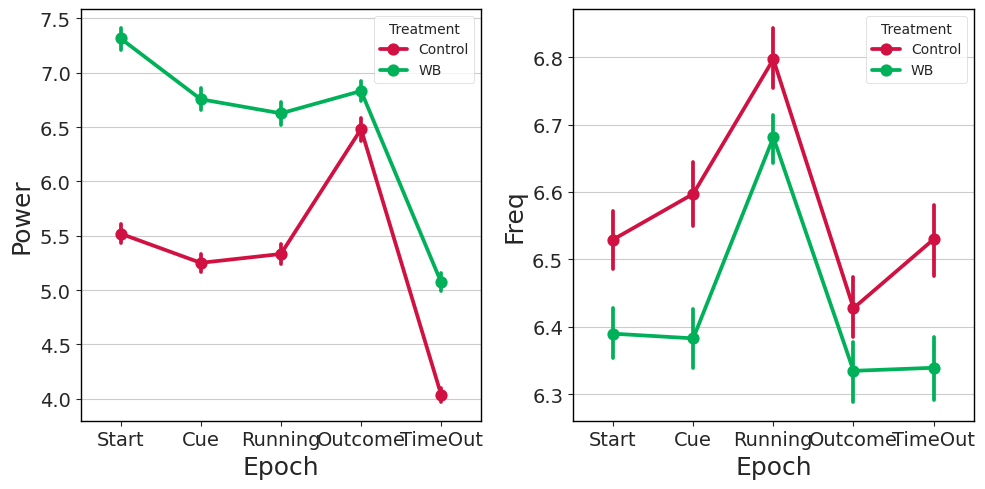

In [ ]:
fig, ax = plt.subplots(1,2,figsize= (10,5))
hax = ax[0]
sns.pointplot(ax = hax, data = xdf, x = 'Epoch', y = 'Power', hue = 'Treatment')

hax = ax[1]
sns.pointplot(ax = hax, data = xdf, x = 'Epoch', y = 'Freq', hue = 'Treatment')

plt.tight_layout()
plt.show()

In [ ]:
# Assuming 'TimeOut' is a value in the 'Epoch' column
# Replace 'TimeOut' with the actual value if it's different
baseline_epoch = 'TimeOut'

# Initialize list to store z-scores
z_scores = []

# Iterate over unique groups of Rec, Treatment, Hemisphere, Structure, and Epoch
for rec, treatment, hemisphere, structure, epoch in xdf[['Rec', 'Treatment', 'Hemisphere', 'Structure', 'Epoch']].drop_duplicates().values:
    # Filter the DataFrame for the current group and baseline epoch
    group_df = xdf[(xdf['Rec'] == rec) & (xdf['Treatment'] == treatment) & (xdf['Hemisphere'] == hemisphere) & (xdf['Structure'] == structure) & (xdf['Epoch'] == epoch)]
    baseline_df = xdf[(xdf['Rec'] == rec) & (xdf['Treatment'] == treatment) & (xdf['Hemisphere'] == hemisphere) & (xdf['Structure'] == structure) & (xdf['Epoch'] == baseline_epoch)]

    # Calculate z-score using the baseline epoch
    baseline_power_mean = baseline_df['Power'].mean()
    baseline_power_std = baseline_df['Power'].std()
    z_score = (group_df['Power'] - baseline_power_mean) / baseline_power_std
    z_scores.extend(z_score)

# Add the z-scores to the DataFrame
xdf['ZScore'] = z_scores


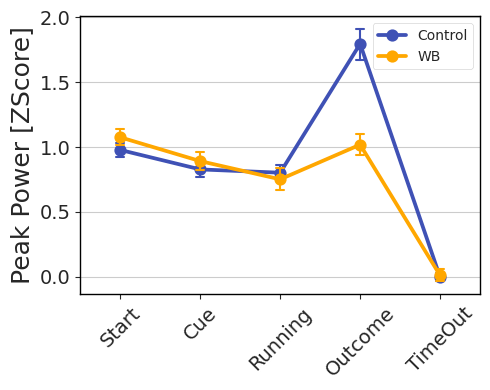

GLME Intercept: -0.00, GLME Treatment Effect p-value: 8.26e-01, nControl-WB=[388, 286]
                   Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       ZScore    
No. Observations:         3370          Method:                   REML      
No. Groups:               7             Scale:                    0.4769    
Min. group size:          310           Log-Likelihood:           -3569.9350
Max. group size:          520           Converged:                No        
Mean group size:          481.4                                             
----------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                        -0.003    0.216  -0.013 0.990 -0.427  0.421
Treatment[T.WB]                   0.012    0.054   0.220 0.826 -0.094  0.117
Epoch[T.S

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# GLME Model instead of 2-Way ANOVA
fig, ax = plt.subplots(1,1, figsize = (5,4))
band = 'Theta'
var = 'ZScore'
data = xdf.copy()

data.Epoch[data.Epoch == 'Reward'] = 'Outcome'
data['Epoch'] = pd.Categorical(data['Epoch'], categories=['TimeOut'] + [cat for cat in data['Epoch'].unique() if cat != 'TimeOut'], ordered=True)
data['Trial'] = data.groupby('Rec').cumcount() + 1
data = data.groupby(['Rec', 'Epoch', 'Outcome', 'Structure', 'Treatment', 'Hemisphere'])[var].mean().reset_index()
data.dropna(subset = [var], inplace = True)

# Plotting
sns.pointplot(ax = ax, data = data, x = 'Epoch', y = var, order = bEpoch, hue = 'Treatment',
              hue_order = ['Control', 'WB'], palette = ttxpalette(['Control', 'WB']),
              capsize=0.1, errwidth = 1.5)
ax.legend(loc = 'upper right').set_title(None)
ax.set_xlabel(None)
ax.set_ylabel('Peak Power [ZScore]')
ax.set_xticklabels(bEpoch, rotation = 45)

fname = f'Global_PeakPower_{band}.png'
plt.tight_layout()
plt.savefig(picFolder + fname, dpi=200, format=None, metadata=None, bbox_inches=None, pad_inches=0.1, facecolor='white', edgecolor='auto', backend=None)
plt.show()

# Check for Missing Values
if pd.isnull(data).values.any():
    print("Warning: Data contains missing values. GLME results may be inaccurate.")
    data = data.dropna()  # Drop rows with missing values before proceeding

# GLME Formula (random effect on Rec structure)
formula = f'{var} ~ Treatment * Epoch'
glme_model = smf.mixedlm(formula, data=data, groups=data['Structure'])  # Replace 'Structure' with random factor
glme_results = glme_model.fit()

# Extracting model parameters for reporting
intercept_val = glme_results.params['Intercept']
treatment_pval = glme_results.pvalues.get('Treatment[T.WB]')  # Adjust for exact term name

# Group counts for nControl-WB
n_control = data[(data['Treatment'] == 'Control') & (data.Epoch == 'TimeOut')].shape[0]
n_wb = data[(data['Treatment'] == 'WB') & (data.Epoch == 'TimeOut')].shape[0]

# Report in specified format
report = (
    f"GLME Intercept: {intercept_val:.2f}, GLME Treatment Effect p-value: {treatment_pval:.2e}, nControl-WB=[{n_control}, {n_wb}]")

print(report)

# GLME Model Summary
print(glme_results.summary())

# Post-hoc Tukey Test for Each Epoch
print("Post-hoc Tukey's HSD Test Results by Epoch:")
for epoch in bEpoch:  # Iterate through unique Epoch values
    print(f"\nEpoch: {epoch}")

    # Ensure Enough Groups for Comparison
    epoch_data = data[data.Epoch == epoch]
    if len(epoch_data['Treatment'].unique()) < 2:
        print("  Not enough groups for comparison.")
        continue

    posthoc = pairwise_tukeyhsd(
        epoch_data[var], epoch_data['Treatment'], alpha=0.05
    )
    print(posthoc)

# Post-hoc Tukey Test by Treatment
print("\nPost-hoc Tukey's HSD Test Results (by Treatment):")
for treatment in data['Treatment'].unique():
    print(f"\nTreatment: {treatment}")

    # Ensure Enough Epochs for Comparison
    treatment_data = data[data.Treatment == treatment]
    if len(treatment_data['Epoch'].unique()) < 2:
        print("  Not enough epochs for comparison.")
        continue

    posthoc = pairwise_tukeyhsd(
        treatment_data[var], treatment_data['Epoch'], alpha=0.05
    )
    print(posthoc)


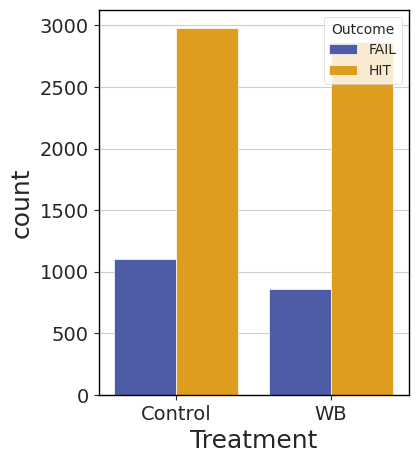

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (4,5))
sns.countplot(data = S[S.Epoch == 'Start'], ax = ax, x = 'Treatment', hue = 'Outcome')
plt.show()

In [ ]:
import pandas as pd
import numpy as np

data = xdf[np.in1d(xdf.Epoch, ['Running', 'Outcome'])]

# Initialize list to store z-scores
xshift = []
xrec = []
xtreatment = []
xhemisphere = []
xstructure = []
xoutcome = []
# Iterate over unique groups of Rec, Treatment, Hemisphere, Structure, and Epoch
for rec, treatment, hemisphere, structure, outcome in data[['Rec', 'Treatment', 'Hemisphere', 'Structure', 'Outcome']].drop_duplicates().values:
    # Filter the DataFrame for the current group and baseline epoch
    run_df = data[(data['Rec'] == rec) & (data['Treatment'] == treatment) & (data['Hemisphere'] == hemisphere) & (data['Outcome'] == outcome) & (data['Structure'] == structure) & (data['Epoch'] == 'Running')]
    rw_df = data[(data['Rec'] == rec) & (data['Treatment'] == treatment) & (data['Hemisphere'] == hemisphere) & (data['Outcome'] == outcome) & (data['Structure'] == structure) & (data['Epoch'] == 'Outcome')]

    if len(run_df) != len(rw_df):
      continue
    else:
      dummy = (np.array(rw_df['ZScore']) - np.array(run_df['ZScore']))
      xshift.extend(dummy)
      xrec.extend(np.repeat(rec, len(run_df)))
      xtreatment.extend(np.repeat(treatment, len(run_df)))
      xhemisphere.extend(np.repeat(hemisphere, len(run_df)))
      xstructure.extend(np.repeat(structure, len(run_df)))
      xoutcome.extend(np.repeat(outcome, len(run_df)))


# Add the z-scores to the DataFrame
xdf2 = pd.DataFrame({'Rec': xrec, 'Treatment': xtreatment, 'Hemisphere': xhemisphere, 'Structure': xstructure,'Outcome': xoutcome, 'Shift': xshift})


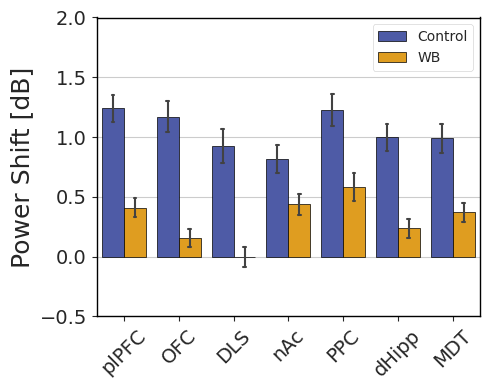

GLME Intercept: 0.93, GLME Treatment Interaction p-value: 3.85e-08
                    Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       Shift      
No. Observations:         7382          Method:                   REML       
No. Groups:               25            Scale:                    6.0065     
Min. group size:          188           Log-Likelihood:           -17115.3130
Max. group size:          429           Converged:                Yes        
Mean group size:          295.3                                              
-----------------------------------------------------------------------------
                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                           0.935    0.124  7.536 0.000  0.691  1.178
Structure[T.MDT]                    0.058    0.151  0.385 0.700 -0.238  0.355
Structure[T.OFC] 

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Define the structures
bStructure = ['plPFC', 'OFC', 'DLS', 'nAc', 'PPC', 'dHipp', 'MDT']

# Set up figure
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

var = 'Shift'
data = xdf2.copy()

data['Outcome'] = pd.Categorical(data['Outcome'], categories=['HIT', 'FAIL'], ordered=True)
data['Trial'] = data.groupby('Rec').cumcount() + 1
data = data.groupby(['Rec', 'Outcome', 'Structure', 'Treatment', 'Hemisphere', 'Trial'])[var].mean().reset_index()
data.dropna(subset = [var], inplace = True)

# Bar plot with GLME update
hax = ax
sns.barplot(
    ax=hax, data=data, x='Structure', y=var, order=bStructure, hue='Treatment', dodge=True,
    palette=ttxpalette(['Control', 'WB']), capsize=0.1, errwidth=1.5, edgecolor='k', ci=68
)

# Customize plot
hax.legend(loc='upper right').set_title(None)
hax.set_xlabel(None)
hax.set_ylabel('Power Shift [dB]')
hax.set_xticklabels(bStructure, rotation=45)
hax.set_ylim([-0.5, 2])

# Save plot
fname = 'Structures_PowerShift.png'
plt.tight_layout()
#plt.savefig(picFolder + fname, dpi=200, format=None, metadata=None, bbox_inches=None, pad_inches=0.1, facecolor='white', edgecolor='auto', backend=None)
plt.show()

# Fit GLME model with random intercepts for recordings
formula = f'{var} ~ Structure + Treatment + Structure:Treatment'
model = smf.mixedlm(formula, data=data, groups=data['Rec']).fit(reml=True)

# Print GLME results summary
print(f'GLME Intercept: {model.fe_params["Intercept"]:.2f}, GLME Treatment Interaction p-value: {model.pvalues["Treatment[T.WB]"]:.2e}')

print(model.summary())

# Post-hoc Tukey tests for each structure
for structure in bStructure:
    NControl = len(data[(data.Treatment =="Control") & (data.Structure == structure)])
    NWB = len(data[(data.Treatment =="WB") & (data.Structure == structure)])
    print(f'\n{structure}: nControl-WB=[{NControl}, {NWB}]' )
    m_comp = pairwise_tukeyhsd(
        endog=data[var][data.Structure == structure],
        groups=data[data.Structure == structure]['Treatment'],
        alpha=0.05
    )
    print(m_comp)


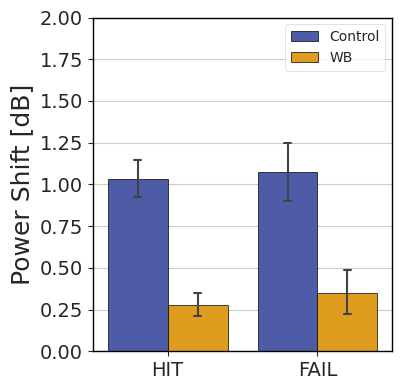

GLME Intercept: 1.04, GLME Treatment Effect p-value: 1.00e-29, HIT: nControl-WB=[2685, 2831, FAIL: nControl-WB=[1032, 834]
                   Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Shift      
No. Observations:       7382          Method:                   REML       
No. Groups:             7             Scale:                    6.0488     
Min. group size:        654           Log-Likelihood:           -17126.9610
Max. group size:        1156          Converged:                Yes        
Mean group size:        1054.6                                             
---------------------------------------------------------------------------
                                Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                        1.037    0.065  16.070 0.000  0.911  1.164
Outcome[T.FAIL]                  0.040    0.090   0.439 0.66

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the figure for visualization
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# Define variable and process the data to group by mean Shift per Treatment, Structure, and Outcome
var = 'Shift'
data = xdf2.copy()
data['Outcome'] = pd.Categorical(data['Outcome'], categories=['HIT', 'FAIL'], ordered=True)
data['Trial'] = data.groupby('Rec').cumcount() + 1
data = data.groupby(['Rec', 'Outcome', 'Structure', 'Treatment', 'Hemisphere', 'Trial'])[var].mean().reset_index()
data.dropna(subset = [var], inplace = True)

# Plot data
sns.barplot(ax=ax, data=data, x='Outcome', y=var, order=['HIT', 'FAIL'], hue='Treatment',
            hue_order=['Control', 'WB'], palette=ttxpalette(['Control', 'WB']),
            capsize=0.1, errwidth=1.5, edgecolor='k')

ax.legend(loc='upper right').set_title(None)
ax.set_xlabel(None)
ax.set_ylim([0, 2])
ax.set_ylabel('Power Shift [dB]')

fname = f'Global_PowerShift.png'
plt.tight_layout()
plt.savefig(picFolder + fname, dpi=200, format=None, metadata=None, bbox_inches=None, pad_inches=0.1, facecolor='white', edgecolor='auto', backend=None)
plt.show()

# GLME Formula (random effect on Rec structure)
formula = f'{var} ~ Outcome * Treatment'
glme_model = smf.mixedlm(formula, data=data, groups=data['Structure'])  # Replace 'Structure' with random factor
glme_results = glme_model.fit()

# Extracting model parameters for reporting
intercept_val = glme_results.params['Intercept']
treatment_pval = glme_results.pvalues.get('Treatment[T.WB]')  # Adjust for exact term name

# Group counts for nControl-WB
n_control_hit = data[(data['Treatment'] == 'Control') & (data.Outcome == 'HIT')].shape[0]
n_wb_hit = data[(data['Treatment'] == 'WB') & (data.Outcome == 'HIT')].shape[0]
n_control_fail = data[(data['Treatment'] == 'Control') & (data.Outcome == 'FAIL')].shape[0]
n_wb_fail = data[(data['Treatment'] == 'WB') & (data.Outcome == 'FAIL')].shape[0]

# Report in specified format
report = (
    f"GLME Intercept: {intercept_val:.2f}, GLME Treatment Effect p-value: {treatment_pval:.2e}, HIT: nControl-WB=[{n_control_hit}, {n_wb_hit}, FAIL: nControl-WB=[{n_control_fail}, {n_wb_fail}]")

print(report)

# GLME Model Summary
print(glme_results.summary())


# Conduct pairwise post-hoc comparisons if significant interaction effect is found
print("\nPost-hoc Tukey's HSD Test Results by Treatment:")
for outcome in ['HIT', 'FAIL']:
    print(f'\nOutcome: {outcome}')
    posthoc = pairwise_tukeyhsd(data[var][data.Outcome == outcome], data[data.Outcome == outcome]['Treatment'], alpha=0.05)
    print(posthoc)

print("\nPost-hoc Tukey's HSD Test Results by Outcome:")
for treatment in ['Control', 'WB']:
    print(f'\nTreatment: {treatment}')
    posthoc = pairwise_tukeyhsd(data[var][data.Treatment == treatment], data[data.Treatment == treatment]['Outcome'], alpha=0.05)
    print(posthoc)



Overall change in frequency

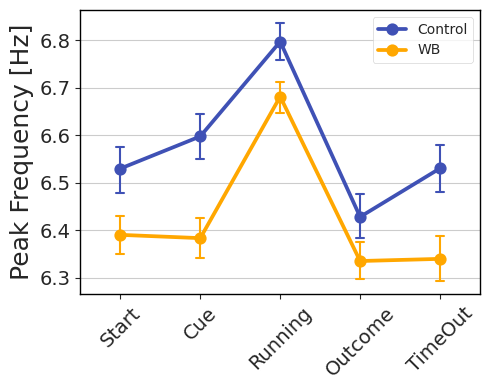

GLME Intercept: 6.53, GLME Treatment Interaction p-value: 1.37e-03, nControl-WB=[4081, 3726]
                   Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       Freq       
No. Observations:        38952         Method:                   REML       
No. Groups:              26            Scale:                    1.9678     
Min. group size:         973           Log-Likelihood:           -68511.3041
Max. group size:         2145          Converged:                Yes        
Mean group size:         1498.2                                             
----------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         6.530    0.043 150.601 0.000  6.445  6.615
Epoch[T.Start]                   -0.001    0.031  -0.021 0.983 -0.062  0.060
Epo

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
import matplotlib.pyplot as plt


# Set up figure
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
band = 'Theta'
var = 'Freq'
data = xdf.copy()

data['Outcome'] = pd.Categorical(data['Outcome'], categories=['HIT', 'FAIL'], ordered=True)
data['Epoch'] = pd.Categorical(data['Epoch'], categories=['TimeOut'] + [cat for cat in data['Epoch'].unique() if cat != 'TimeOut'], ordered=True)
data['Trial'] = data.groupby('Rec').cumcount() + 1
#data = data.groupby(['Rec', 'Epoch', 'Outcome', 'Structure', 'Treatment', 'Hemisphere'])[var].mean().reset_index()
data = data.groupby(['Rec', 'Outcome', 'Structure', 'Epoch', 'Treatment', 'Hemisphere', 'Trial'])[var].mean().reset_index()
data.dropna(subset = [var], inplace = True)

# Plot with GLME update
hax = ax
sns.pointplot(ax=hax, data=data, x='Epoch', y=var, order = bEpoch,
              hue = 'Treatment', hue_order=['Control', 'WB'], palette=ttxpalette(['Control', 'WB']), capsize=0.1, errwidth=1.5)

# Customize plot
hax.legend(loc='upper right').set_title(None)
hax.set_xlabel(None)
hax.set_ylabel('Peak Frequency [Hz]')
hax.set_xticklabels(bEpoch, rotation=45)

# Save plot
fname = f'Global_PeakFreq_{band}.png'
plt.tight_layout()
plt.savefig(picFolder + fname, dpi=200, format=None, metadata=None, bbox_inches=None, pad_inches=0.1, facecolor='white', edgecolor='auto', backend=None)
plt.show()

# Fit GLME model with random intercepts for recordings
formula = f'{var} ~ Epoch + Treatment + Epoch:Treatment'
model = smf.mixedlm(formula, data=data, groups=data['Rec']).fit(reml=True)

# Print GLME results summary
NControl = len(data[(data.Treatment =="Control") & (data.Epoch == 'TimeOut')])
NWB = len(data[(data.Treatment =="WB") & (data.Epoch == 'TimeOut')])
print(f'GLME Intercept: {model.fe_params["Intercept"]:.2f}, GLME Treatment Interaction p-value: {model.pvalues["Treatment[T.WB]"]:.2e}, nControl-WB=[{NControl}, {NWB}]')

print(model.summary())

# Post-hoc Tukey tests for each epoch
for epoch in bEpoch:
    print(f'\n{epoch}:')
    m_comp = pairwise_tukeyhsd(
        endog=data[var][data.Epoch == epoch],
        groups=data[data.Epoch == epoch]['Treatment'],
        alpha=0.05
    )
    print(m_comp)


In [ ]:
Data.Epoch[Data.Epoch == 'Reward'] = 'Outcome'

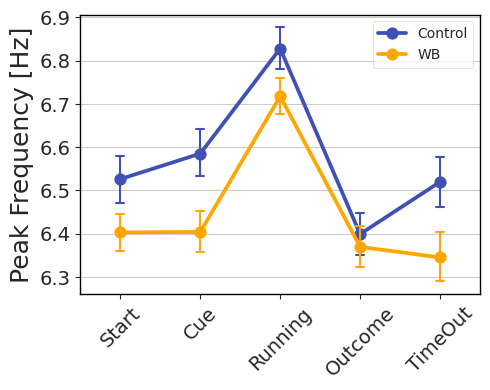

                       sum_sq       df          F        PR(>F)
Epoch              541.207291      4.0  69.123022  2.416155e-58
Treatment          111.528798      1.0  56.977855  4.536119e-14
Epoch:Treatment     21.705652      4.0   2.772247  2.560064e-02
Residual         57068.173890  29155.0        NaN           NaN


Start:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj  lower   upper  reject
----------------------------------------------------
Control     WB  -0.1231 0.0006 -0.193 -0.0533   True
----------------------------------------------------

Cue:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj  lower   upper  reject
----------------------------------------------------
Control     WB  -0.1809   0.0 -0.2556 -0.1062   True
----------------------------------------------------

Running:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj   lower   upper  reject
-----------------

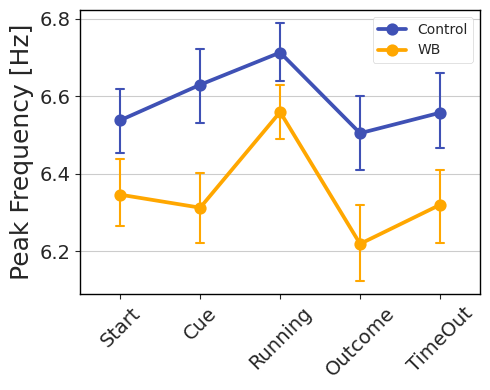

                       sum_sq      df          F        PR(>F)
Epoch               76.349895     4.0   9.210791  2.001613e-07
Treatment          136.016898     1.0  65.635886  6.073052e-16
Epoch:Treatment      8.598205     4.0   1.037281  3.862597e-01
Residual         20260.825098  9777.0        NaN           NaN


Start:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj   lower   upper  reject
-----------------------------------------------------
Control     WB  -0.1922 0.0021 -0.3149 -0.0695   True
-----------------------------------------------------

Cue:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj  lower   upper  reject
----------------------------------------------------
Control     WB  -0.3177   0.0 -0.4482 -0.1872   True
----------------------------------------------------

Running:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj   lower   upper  reject
-----------------

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

band = 'Theta'
var = 'Freq'

data = xdf.copy()
data['Outcome'] = pd.Categorical(data['Outcome'], categories=['HIT', 'FAIL'], ordered=True)
data['Trial'] = data.groupby('Rec').cumcount() + 1
data = data.groupby(['Rec', 'Outcome', 'Structure', 'Epoch', 'Treatment', 'Hemisphere', 'Trial'])[var].mean().reset_index()
data.dropna(subset = [var], inplace = True)


for outcome in ['HIT', 'FAIL']:
  fig, ax = plt.subplots(1,1, figsize = (5,4))
  hax = ax
  sel = data.Outcome == outcome
  sns.pointplot(ax = ax, data = data[sel], x = 'Epoch', y = var, order = bEpoch, hue = 'Treatment',
                hue_order = ['Control', 'WB'], palette = ttxpalette(['Control', 'WB']),
                capsize=0.1, errwidth = 1.5)
  hax.legend(loc = 'upper right').set_title(None)
  hax.set_xlabel(None)
  hax.set_ylabel('Peak Frequency [Hz]')
  hax.set_xticklabels(bEpoch, rotation = 45)
  fname = f'Global_PeakFreq_{band}-{outcome}.png'
  plt.tight_layout()
  plt.savefig(picFolder + fname, dpi=200, format=None, metadata=None, bbox_inches=None, pad_inches=0.1, facecolor='white', edgecolor='auto', backend=None)
  plt.show()


  # Perform 2-way ANOVA
  formula = f'{var} ~ Epoch + Treatment + Epoch*Treatment'
  model = ols(formula, data=data[sel]).fit()
  aov_table = sm.stats.anova_lm(model, typ=2)
  print(f'{aov_table}\n')

  # Post-hoc Tukey test
  for epoch in bEpoch:
    print(f'\n{epoch}:')
    sel2 = sel & (data.Epoch == epoch)
    m_comp = pairwise_tukeyhsd(endog=data[var][sel2], groups=data[sel2]['Treatment'], alpha=0.05)
    print(m_comp)


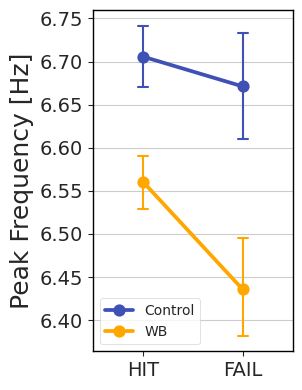

                   Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Freq       
No. Observations:       15542         Method:                   REML       
No. Groups:             858           Scale:                    1.8412     
Min. group size:        1             Log-Likelihood:           -26854.1972
Max. group size:        26            Converged:                Yes        
Mean group size:        18.1                                               
---------------------------------------------------------------------------
                                Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                        6.710    0.018 366.810 0.000  6.674  6.745
Outcome[T.FAIL]                 -0.033    0.034  -0.979 0.328 -0.100  0.033
Treatment[T.WB]                 -0.147    0.025  -5.809 0.000 -0.196 -0.097
Outcome[T.FAIL]:Treatment[T.WB]

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd

fig, ax = plt.subplots(1, 1, figsize=(3, 4))
band = 'Theta'
var = 'Freq'
hax = ax
data = xdf[np.in1d(xdf.Epoch, ['Cue', 'Running'])]
data['Outcome'] = pd.Categorical(data['Outcome'], categories=['HIT', 'FAIL'], ordered=True)
data['Trial'] = data.groupby('Rec').cumcount() + 1
data = data.groupby(['Rec', 'Outcome', 'Structure', 'Hemisphere', 'Treatment', 'Trial'])[var].mean().reset_index()
data.dropna(subset = [var], inplace = True)

# Plotting
sns.pointplot(ax=ax, data=data, x='Outcome', y=var, hue='Treatment',
              hue_order=['Control', 'WB'], order=['HIT', 'FAIL'],
              palette=ttxpalette(['Control', 'WB']), capsize=0.1, errwidth=1.5)
hax.legend(loc='lower left').set_title(None)
hax.set_xlabel(None)
hax.set_ylabel('Peak Frequency [Hz]')
plt.tight_layout()
plt.show()

# Perform GLME
formula = f'{var} ~ Outcome * Treatment'
# Assuming 'Rec' as the random effect variable
model = mixedlm(formula, data=data, groups=data['Trial']).fit()
print(model.summary())

# Post-hoc Tukey tests
for outcome in ['HIT', 'FAIL']:
    sel_outcome = data['Outcome'] == outcome
    m_comp = pairwise_tukeyhsd(endog=data[sel_outcome][var], groups=data[sel_outcome]['Treatment'], alpha=0.05)
    print(f"\nOutcome: {outcome} - Control={np.nansum((sel_outcome) & (data.Treatment == 'Control'))}, WB={np.nansum((sel_outcome) & (data.Treatment == 'WB'))}")
    print(m_comp)

for treatment in ['Control', 'WB']:
    print(f'\nTreatment: {treatment}')
    sel_treatment = data['Treatment'] == treatment
    m_comp = pairwise_tukeyhsd(endog=data[sel_treatment][var], groups=data[sel_treatment]['Outcome'], alpha=0.05)
    print(m_comp)


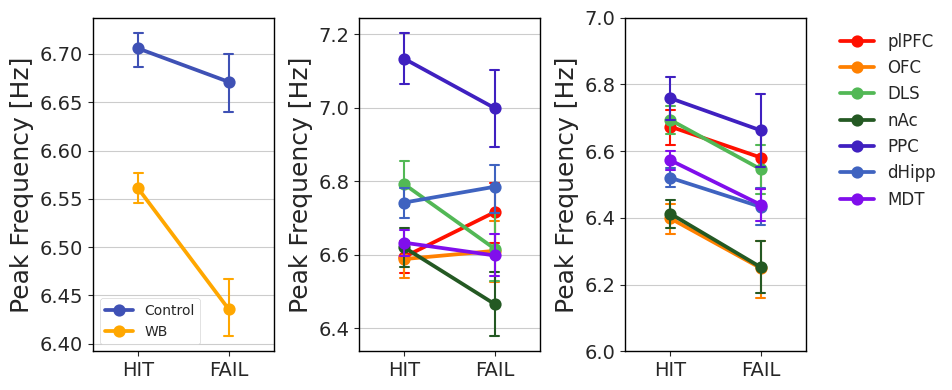

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

bpalette = strpalette(bStructure)

fig, ax = plt.subplots(1,3, figsize = (10,4), sharey = False)
band = 'Theta'
var = 'Freq'
data = xdf[np.in1d(xdf.Epoch, ['Cue', 'Running'])]

data['Outcome'] = pd.Categorical(data['Outcome'], categories=['HIT', 'FAIL'], ordered=True)
data['Trial'] = data.groupby('Rec').cumcount() + 1
data = data.groupby(['Rec', 'Outcome', 'Structure', 'Hemisphere', 'Treatment', 'Trial'])[var].mean().reset_index()
data.dropna(subset = [var], inplace = True)
data.reset_index(drop= True, inplace = True)


hax = ax[0]
sns.pointplot(ax = hax, data = data, x = 'Outcome', y = var, hue = 'Treatment', hue_order = ['Control', 'WB'], order = ['HIT', 'FAIL'],
              palette = ttxpalette(['Control', 'WB']), capsize=0.1, errwidth = 1.5, ci = 68)
hax.legend(loc = 'lower left').set_title(None)
hax.set_xlabel(None)
hax.set_ylabel('Peak Frequency [Hz]')


YLim = [6, 7.0]
hax = ax[1]
sel = (data.Treatment == 'Control')
sns.pointplot(ax = hax, data = data[sel], x = 'Outcome', y = var, hue = 'Structure', hue_order = bStructure, order = ['HIT', 'FAIL'],
              palette = strpalette(bStructure), capsize=0.1, errwidth = 1.5, ci = 68, legend = False)
hax.set_xlabel(None)
hax.set_ylabel('Peak Frequency [Hz]')
#hax.set_ylim(YLim)

hax = ax[2]
sel = (data.Treatment == 'WB')
sns.pointplot(ax = hax, data = data[sel], x = 'Outcome', y = var, hue = 'Structure', hue_order = bStructure, order = ['HIT', 'FAIL'],
              palette = strpalette(bStructure), capsize=0.1, errwidth = 1.5, ci = 68)
hax.legend(loc = 'upper right', fontsize = 12, bbox_to_anchor=(1, 1, 0.8, 0), frameon = False).set_title(None)
hax.set_xlabel(None)
hax.set_ylabel('Peak Frequency [Hz]')
hax.set_ylim(YLim)

fname = f'Global_PeakFreq_byOutcome.png'
plt.tight_layout()
plt.savefig(picFolder + fname, dpi=200, format=None, metadata=None, bbox_inches=None, pad_inches=0.1, facecolor='white', edgecolor='auto', backend=None)
plt.show()



In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_ind, mannwhitneyu, shapiro, wilcoxon, ttest_rel
import pandas as pd

band = 'Theta'
var = 'Freq'
formula = f'{var} ~ Outcome * Structure + Outcome + Structure'

for ttx in ['Control', 'WB']:
    print(f'\nTreatment: {ttx}\n')

    # Filter data for the specific structure and epochs
    data = xdf[np.in1d(xdf.Epoch, ['Cue', 'Running']) & (xdf.Treatment == ttx)]
    data['Outcome'] = pd.Categorical(data['Outcome'], categories=['HIT', 'FAIL'], ordered=True)

    data.dropna(subset = [var], inplace = True)
    data['Trial'] = data.groupby('Rec').cumcount() + 1
    data = data.groupby(['Rec', 'Outcome', 'Structure', 'Hemisphere', 'Trial'])[var].mean().reset_index()

    # Check normality for t-test suitability
    h = shapiro(data[var]).pvalue > 0.05
    #h = True
    for structure in bStructure:
        print('----------')
        print(f'{structure}')

        # Filter data for the specific structure
        sel_treatment = data['Structure'] == structure

        if h:
            # Perform independent t-test on averaged data
            t_stat, p_value = ttest_rel(
                data[var][(sel_treatment) & (data.Outcome == 'HIT')],
                data[var][(sel_treatment) & (data.Outcome == 'FAIL')],
                nan_policy='omit'
            )
            test_used = "t-test"
        else:
            # Perform test on averaged data
            t_stat, p_value = wilcoxon(
                data[var][(sel_treatment) & (data.Outcome == 'HIT')],
                data[var][(sel_treatment) & (data.Outcome == 'FAIL')],
                alternative='two-sided', nan_policy='omit'
            )
            test_used = "Wilcoxon test"

        # Print results
        print(f'{test_used} results: t-statistic/U: {t_stat:.4f}, p-value: {p_value:.4e}')


In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_ind, mannwhitneyu, shapiro, wilcoxon, ttest_rel
import pandas as pd

band = 'Theta'
var = 'Freq'
formula = f'{var} ~ Outcome * Structure + Outcome + Structure'

for ttx in ['Control', 'WB']:
    print(f'\nTreatment: {ttx}')

    # Filter data for the specific structure and epochs
    data = xdf[np.in1d(xdf.Epoch, ['Start', 'Cue', 'Running']) & (xdf.Treatment == ttx)]
    data['Outcome'] = pd.Categorical(data['Outcome'], categories=['HIT', 'FAIL'], ordered=True)

    # Average Freq by Rec
    avg_data = data.groupby(['Rec', 'Outcome', 'Structure'])[var].mean().reset_index()


    # Check normality for t-test suitability
    #h = shapiro(avg_data[var]).pvalue > 0.05
    h = True
    for structure in bStructure:
        print('----------')
        print(f'{structure}')

        # Filter data for the specific structure
        sel_treatment = avg_data['Structure'] == structure

        # Perform independent t-test on averaged data
        h = bootstrap_test(
            avg_data[var][(sel_treatment) & (avg_data.Outcome == 'HIT')],
            avg_data[var][(sel_treatment) & (avg_data.Outcome == 'FAIL')])
        test_used = "bootstrapping test"


        # Print results
        #print(f'{test_used} results: t-statistic/U: {t_stat:.4f}, p-value: {p_value:.4f}')
        print(f'{test_used} results: \n{h}\n')
